<a href="https://colab.research.google.com/github/AbhyanandSharma2005/ML-model-practice-on-real-data/blob/main/Decision%20Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Generating Synthetic Data ---
Dataset shape: X=(500, 4), y=(500,)
Class distribution: Counter({np.int64(1): 252, np.int64(0): 248})
Training samples: 375, Test samples: 125
Training class distribution (0/1): Counter({np.int64(1): 189, np.int64(0): 186})
Test class distribution (0/1): Counter({np.int64(1): 63, np.int64(0): 62})

--- Training Decision Tree Classifier ---
Decision Tree training complete.

--- Evaluating Model Performance ---
Accuracy on test set: 0.9520

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        62
           1       0.95      0.95      0.95        63

    accuracy                           0.95       125
   macro avg       0.95      0.95      0.95       125
weighted avg       0.95      0.95      0.95       125


--- Visualizing Decision Boundary (after PCA to 2D) ---


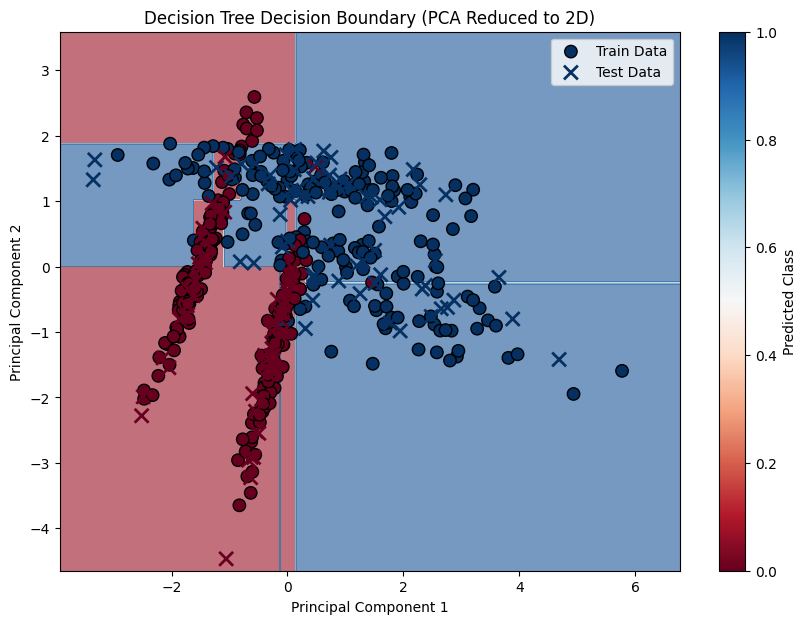

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification # For generating synthetic data

# --- 1. Node Class ---
class Node:
    """
    Represents a node in the Decision Tree.
    """
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        """
        Args:
            feature_index (int, optional): Index of the feature to split on.
            threshold (float, optional): Value to split the feature by.
            left (Node, optional): Left child node.
            right (Node, optional): Right child node.
            value (any, optional): Class label if this is a leaf node.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value # This will be the predicted class if it's a leaf node

    def is_leaf_node(self):
        """
        Checks if the node is a leaf node.
        """
        return self.value is not None

# --- 2. Decision Tree Classifier Class ---
class DecisionTreeClassifier:
    """
    Decision Tree Classifier implemented from scratch.
    Uses Gini impurity for splitting.
    """
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        """
        Args:
            min_samples_split (int): Minimum number of samples required to split an internal node.
            max_depth (int): Maximum depth of the tree.
            n_features (int, optional): Number of features to consider for best split.
                                         If None, all features are considered.
                                         Useful for RandomForest, not strictly necessary for single DT.
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None # The root node of the decision tree

    def fit(self, X, y):
        """
        Builds the decision tree by recursively splitting the data.

        Args:
            X (numpy.ndarray): Training features, shape (n_samples, n_features).
            y (numpy.ndarray): Target labels, shape (n_samples,).
        """
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        """
        Recursively grows the tree.
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check stopping criteria:
        # 1. Max depth reached
        # 2. All samples belong to the same class (pure node)
        # 3. Not enough samples to split
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False) # Random subset of features
        best_feat_idx, best_threshold = self._best_split(X, y, feat_idxs)

        # If no good split found (e.g., all samples are identical)
        if best_feat_idx is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Split the data
        left_idxs = X[:, best_feat_idx] <= best_threshold
        right_idxs = X[:, best_feat_idx] > best_threshold

        # Recursively build left and right subtrees
        left_child = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_child = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feat_idx, best_threshold, left_child, right_child)

    def _best_split(self, X, y, feat_idxs):
        """
        Finds the best feature and threshold to split the data.
        Returns (best_feature_index, best_threshold).
        """
        best_gini_gain = -1
        split_idx, split_threshold = None, None

        current_gini = self._gini_impurity(y)

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column) # Consider all unique values as potential thresholds

            for threshold in thresholds:
                # Split the data based on the current feature and threshold
                left_idxs = X_column <= threshold
                right_idxs = ~left_idxs # Inverse of left_idxs

                if len(y[left_idxs]) == 0 or len(y[right_idxs]) == 0:
                    continue # Skip empty splits

                # Calculate weighted average Gini of children
                n_left = len(y[left_idxs])
                n_right = len(y[right_idxs])
                n_total = len(y)

                gini_left = self._gini_impurity(y[left_idxs])
                gini_right = self._gini_impurity(y[right_idxs])

                gini_children = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right

                # Calculate information gain (reduction in impurity)
                gini_gain = current_gini - gini_children

                if gini_gain > best_gini_gain:
                    best_gini_gain = gini_gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _gini_impurity(self, y):
        """
        Calculates the Gini impurity of a given set of labels.
        Gini = 1 - sum(p_i^2)
        """
        if len(y) == 0:
            return 0.0

        class_counts = Counter(y)
        impurity = 1.0
        for label in class_counts:
            prob_of_label = class_counts[label] / len(y)
            impurity -= prob_of_label**2
        return impurity

    def _most_common_label(self, y):
        """
        Returns the most common class label in a set of labels.
        Used for leaf node prediction.
        """
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0] # Returns a list of (element, count) tuples
        return most_common

    def predict(self, X):
        """
        Predicts class labels for new samples.
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        """
        Recursively traverses the tree to make a prediction for a single sample.
        """
        if node.is_leaf_node():
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

# --- 3. Main Execution Block ---

if __name__ == "__main__":
    print("--- Generating Synthetic Data ---")
    # Generate a synthetic classification dataset
    X, y = make_classification(n_samples=500, n_features=4, n_informative=2,
                               n_redundant=0, n_classes=2, random_state=42)

    print(f"Dataset shape: X={X.shape}, y={y.shape}")
    print(f"Class distribution: {Counter(y)}")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
    print(f"Training class distribution (0/1): {Counter(y_train)}")
    print(f"Test class distribution (0/1): {Counter(y_test)}")

    # --- Initialize and Train the Model ---
    print("\n--- Training Decision Tree Classifier ---")
    # You can play with max_depth and min_samples_split
    dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
    dt_model.fit(X_train, y_train)
    print("Decision Tree training complete.")

    # --- Evaluate the Model ---
    print("\n--- Evaluating Model Performance ---")
    y_pred = dt_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set: {accuracy:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # --- (Optional) Visualization for 2D data ---
    # If your data has only 2 features, you can visualize the decision boundary.
    # For this example, we have 4 features, so direct 2D visualization is not straightforward.
    # You could use PCA to reduce to 2 features for visualization purposes.

    # Example of PCA for visualization (if you want to see a 2D projection)
    try:
        from sklearn.decomposition import PCA
        if X.shape[1] > 2:
            print("\n--- Visualizing Decision Boundary (after PCA to 2D) ---")
            pca = PCA(n_components=2)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Re-train a new model on PCA data for visualization
            dt_model_pca = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
            dt_model_pca.fit(X_train_pca, y_train)

            plt.figure(figsize=(10, 7))

            x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
            y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                                 np.arange(y_min, y_max, 0.02))

            Z = dt_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.6)
            plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.RdBu, edgecolor='k', s=80, label='Train Data')
            plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.RdBu, marker='x', s=100, linewidth=2, label='Test Data')

            plt.title('Decision Tree Decision Boundary (PCA Reduced to 2D)')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(label='Predicted Class')
            plt.legend()
            plt.show()
    except ImportError:
        print("\nSkipping PCA visualization: scikit-learn not installed.")